In [1]:
import csv
import numpy as np
from collections import defaultdict
from matplotlib import pyplot
import pandas

In [2]:
BLANKS=["","RBNF1", "RBNF2", "RBNF", "0", "RBNF 1", "RBNF 2"]
#TOTAL= 5048
TOTAL=2734
#TOTAL=1351
#TOTAL=1201
#TOTAL=1168


In [3]:
def loadCsvData(fileName):
	matrix = []
	# open a file
	with open(fileName) as f:
		reader = csv.reader(f)

		# loop over each row in the file
		for row in reader:

			# cast each value to a float
			doubleRow = []
			for value in row:
				doubleRow.append(value.strip())

			# store the row into our matrix
			matrix.append(doubleRow)
	return matrix

In [4]:
def printData(matrix):
	for row in matrix:
		print (row)

In [5]:
data= loadCsvData("data/metadata.csv")

In [6]:
data=pandas.DataFrame(data[1:], columns=data[0])

In [8]:
interviewtxt =loadCsvData("data/interview text fille to ids.csv")

In [9]:
interviewtxt=pandas.DataFrame(interviewtxt[1:], columns=interviewtxt[0])


In [10]:
text_to_ids={}
for i in range(len(interviewtxt)):
    name=interviewtxt.at[i, interviewtxt.columns[0]]
    name=name[:name.rfind('.')]
    name=name.replace('\'','_')
    text_to_ids[name]=interviewtxt["interviewee_ids"][i].split(';')

In [11]:
ids_to_years=defaultdict(lambda: "0")
for i in range(len(interviewtxt)):
    date=interviewtxt["date_of_first_interview"][i]
    year=date[date.rfind('/')+1:]
    ids=interviewtxt["interviewee_ids"][i].split(';')
    for num in ids:
        ids_to_years[num]= str(year)

In [13]:
database=defaultdict(lambda: defaultdict(lambda:0))
for i in range(len(data)):
    for atr in data.columns:
        if atr== "researcher_assumed_birth_decade":
            continue
        if atr== "researcher_assumed_race":
            continue
        value= data[atr][i]
        if value in BLANKS and atr=="\ufeffbirth_decade":
            value= data.loc[i, "researcher_assumed_birth_decade"]
        if value in BLANKS and atr=="identified_race":
            value= data.loc[i, "researcher_assumed_race"]
        if value in BLANKS and atr == "real_interviewee_birth_year":
            value= data.loc[i, "approximate_interviewee_birth_year"]
        database[data.loc[i, "interviewee_id"]][atr]=value
    database[data.loc[i, "interviewee_id"]]["interview_year"]=ids_to_years[data.loc[i, "interviewee_id"]]

In [17]:
dataformatted=defaultdict(lambda: defaultdict(lambda:0))
for i in database : 
    if database[i]["sex"]=="Male":
        continue
    for atr in database[i]:
        value= database[i][atr]
        if value not in BLANKS:
            dataformatted[atr][value]+=1
print(dataformatted["real_interviewee_birth_year"])
for cat in dataformatted:
    total=0
    for x in dataformatted[cat]:
        total+= dataformatted[cat][x]
    dataformatted[cat]["No Info"]= TOTAL-total
        

    
        

defaultdict(<function <lambda>.<locals>.<lambda> at 0x7fc67e2800d0>, {'1897': 14, '1893': 9, '1902': 14, '1890': 2, '1898': 10, '1915': 36, '1900': 9, '1901': 6, '1888': 2, '1896': 11, '1906': 13, '1904': 6, '1903': 12, '1895': 3, '1899': 7, '1912': 34, '1885': 4, '1935': 52, '1905': 12, '1892': 6, '1910': 16, '1907': 17, '1886': 1, '1884': 1, '1913': 38, '1916': 29, '1917': 30, '1874': 1, '1941': 43, '1938': 50, '1927': 41, '1929': 34, '1945': 63, '1953': 51, '1947': 75, '1933': 31, '1909': 8, '1931': 46, '1943': 70, '1923': 47, '1918': 28, '1944': 70, '1989': 3, '1924': 66, '1930': 42, '1937': 58, '1948': 66, '1966': 10, '1972': 9, '1942': 50, '1925': 62, '1921': 37, 'h': 1, '1946': 60, '1934': 37, '1954': 43, '1922': 59, '1911': 21, '1958': 31, '1891': 3, '1988': 2, '1940': 56, '1957': 38, '1959': 12, '1960': 26, '1952': 49, '1939': 48, '1919': 28, '1914': 28, '1928': 24, '1932': 40, '1950': 51, '1926': 47, '1964': 33, '1908': 13, '1968': 8, '1936': 61, '1962': 22, '1920': 39, '1951

In [ ]:
unknown=[]
for x in database:
    if database[x]['current_or_most_recent_occupation'] in BLANKS and database[x]["sex"]!="Male":
        unknown.append(database[x]["interviewee_name"])


In [ ]:
for table in dataformatted:
    for x,y in dataformatted[table].items():
        print("{}: {}".format(x,y))
        #print(x)
        #print(y)

In [ ]:
#def checkAProfile(data, race, sex, education, birthdecade, exact):
#    total=0
#    attr=[("identified_race", race), ("sex", sex), ("education", education), ("\ufeffbirth_decade", birthdecade)]
#    for i in data: 
#        if exact:
#            skip=False
#            for a in attr:
#                if data[i][a[0]] in BLANKS and a[1] != "":
#                    skip=True
#           if skip:
#                continue
#        skip=False   
#        for a in attr:
#            cat= data[i][a[0]]
#            if a[1] != "" and cat not in BLANKS and cat != a[1]:
#                skip=True
#        if skip:
#            continue
#        total+=1
#    return total
    
    

In [19]:
ids_to_info=defaultdict(lambda: defaultdict(lambda:0))
for ids in database:
    ids_to_info[ids]["birth_decade"]=database[ids]["\ufeffbirth_decade"]
    ids_to_info[ids]["education"]=database[ids]["education"]
    ids_to_info[ids]["collection"]=database[ids]["collection_id"]
    ids_to_info[ids]["sex"]=database[ids]["sex"]
    ids_to_info[ids]["race"]=database[ids]["identified_race"]
    ids_to_info[ids]["interview_year"]=database[ids]["interview_year"]
    ids_to_info[ids]["birth_year"]=database[ids]["real_interviewee_birth_year"]


In [20]:
myfile = open("data/everything_but_falsehits_and_needsreview.txt")
txt = myfile.read()
myfile.close()

files=[]
tokens=txt.split()
for i in tokens:
    num= i.find("Files\\\\")
    if not num==-1:
        if not i.find("_")==-1:
            files.append(i.strip())
names=set()
for i in files:
    i=i[i.find("\\\\",8)+2:-1]
    names.add(i.strip())


In [21]:
decades=[]
for i in range(1870, 2000, 10):
    decades.append(str(i))
decades.append("No Info")
total=[]
for i in decades:
    total.append(dataformatted["\ufeffbirth_decade"][i])
hits=defaultdict(lambda:0)
for x in names:
    id_nums=text_to_ids[x]
    for num in id_nums:
        hits[ids_to_info[num]["birth_decade"]]+=1
hits_formatted=[]
for i in decades:
    hits_formatted.append(hits[i])
percentage_withNI=[]
percentage_noNI=[]
totalnum=sum(total)
print(totalnum)
for i in range(len(decades)):
    percentage_withNI.append(int(hits_formatted[i]/total[i]*100))
    #if not i==len(decades)-1:
    #    percentage_noNI.append(int(hits_formatted[i]/(total[i])*100))
#percentage_noNI.append(None)


2731


In [22]:
df_decades = pandas.DataFrame([total, hits_formatted, percentage_withNI], index=["total corpus", "in rape cluster", "Percentage of total"],columns=decades)

In [23]:
display(df_decades)

,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,No Info
total corpus,2,13,64,109,288,455,466,608,396,184,67,41,8,30
in rape cluster,0,2,14,18,24,56,65,151,90,38,13,7,0,0
Percentage of total,0,15,21,16,8,12,13,24,22,20,19,17,0,0


In [24]:
race=[]
for i in dataformatted["identified_race"]:
    race.append(i)
race.remove("No Info")
race.sort()
race.append("No Info")
total=[]
for i in race:
    total.append(dataformatted["identified_race"][i])
hits=defaultdict(lambda:0)
for x in names:
    id_nums=text_to_ids[x]
    for num in id_nums:
        hits[ids_to_info[num]["race"]]+=1
hits_formatted=[]
for i in race:
    hits_formatted.append(hits[i])
percentage_withNI=[]
percentage_noNI=[]
totalnum=sum(total)
for i in range(len(race)):
    percentage_withNI.append(int(hits_formatted[i]/total[i]*100))
    #if not i==len(race)-1:
    #    percentage_noNI.append(int(hits_formatted[i]/(totalnum-total[-1])*100))
#percentage_noNI.append(None)

In [ ]:
df_race = pandas.DataFrame([total, hits_formatted, percentage_withNI],index=["total corpus", "in rape cluster", "Percentage of total"], columns=race)

In [ ]:
display(df_race)

In [ ]:
education=["Less than 9th grade", "9th to 12th grade but no diploma", "High school graduate", "Some college", "Associate's degree", "Bachelor's degree", "Graduate or professional degree", "No Info"]
total=[]
for i in education:
    total.append(dataformatted["education"][i])
hits=defaultdict(lambda:0)
for x in names:
    id_nums=text_to_ids[x]
    for num in id_nums:
        hits[ids_to_info[num]["education"]]+=1
hits_formatted=[]
for i in education:
    hits_formatted.append(hits[i])
total_correct=[sum(total[0:3]), sum(total[3:6]), total[-2], total[-1]]
hits_formatted_correct=[sum(hits_formatted[0:3]), sum(hits_formatted[3:6]), hits_formatted[-2], hits_formatted[-1]]
percentage_withNI=[]
percentage_noNI=[]
totalnum=sum(total)
for i in range(4):
    percentage_withNI.append(int(hits_formatted_correct[i]/total_correct[i]*100))
    #if not i==3:
    #    percentage_noNI.append((hits_formatted_correct[i]/(totalnum-total[-1])*100))
#percentage_noNI.append(None)

In [ ]:
df_education = pandas.DataFrame([total_correct, hits_formatted_correct, percentage_withNI], index=["total corpus", "in rape cluster", "Percentage of total"], columns=["up to 12th grade", "up to college degree", "graduate or professional degree", "no info"])

In [ ]:
display(df_education)

In [52]:
years=[]
for i in range(1972, 2019, 1):
    years.append(str(i))
years.append("No Info")
total=[]
for i in years:
    total.append(dataformatted["interview_year"][i])
hits=defaultdict(lambda:0)
for x in names:
    id_nums=text_to_ids[x]
    for num in id_nums:
        hits[ids_to_info[num]["interview_year"]]+=1
hits_formatted=[]
for i in years:
    hits_formatted.append(hits[i])
percentage_withNI=[]
percentage_noNI=[]
totalnum=sum(total)
print(totalnum)
for i in range(len(years)):
    if total[i]==0:
        percentage_withNI.append(0)
    else:    
        percentage_withNI.append(int(hits_formatted[i]/total[i]*100))
    #if not i==len(years)-1:
    #    percentage_noNI.append((hits_formatted[i]/(totalnum-total[-1])*100))
#percentage_noNI.append(None)

2732


In [53]:
df_interview_year = pandas.DataFrame([total, hits_formatted, percentage_withNI], index=["total corpus", "in rape cluster", "Percentage of total"], columns=years)

In [54]:
pandas.options.display.max_columns = 10

In [55]:
display(df_interview_year)

,1972,1973,1974,1975,1976,...,2015,2016,2017,2018,No Info
total corpus,4,5,19,9,20,...,121,130,57,9,188
in rape cluster,1,0,4,2,9,...,10,13,12,5,0
Percentage of total,25,0,21,22,45,...,8,10,21,55,0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

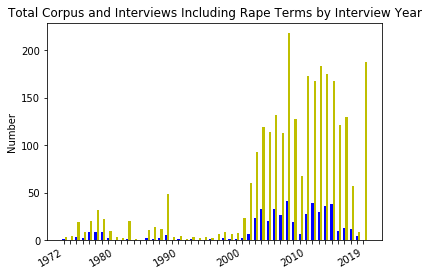

In [56]:
N = 48

ind = np.arange(N) 
values=[]
totals=[]

# some example data

values=hits_formatted
    
    
values = np.array(values)
total=np.array(total)


x = range(len(values))


# and plot it
fig, ax = pyplot.subplots()
hm=ax.bar(ind, values, 0.35, color="b")
total=ax.bar(ind+.35, total, .35, color="y")
ax.set_xticks(ind)
ax.set_xticklabels((1972,"","","","","","","",1980,"","","","","","","","","",1990,"","","","","","","","","",2000,"","","","","","","","","",2010,"","","","","","","","",2019))
ax.set_title('Total Corpus and Interviews Including Rape Terms by Interview Year')
ax.set_ylabel('Number')
pyplot.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')



In [57]:
years=[]
for i in range(1871, 1998):
    years.append(str(i))
years.append("No Info")
total=[]
for i in years:
    total.append(dataformatted["real_interviewee_birth_year"][i])
hits=defaultdict(lambda:0)
print(sum(total))
for x in names:
    id_nums=text_to_ids[x]
    for num in id_nums:
        hits[ids_to_info[num]["birth_year"]]+=1
hits_formatted=[]
for i in years:
    hits_formatted.append(hits[i])
percentage_withNI=[]
for i in range(len(years)):
    if total[i]==0:
        percentage_withNI.append(0)
    else:    
        percentage_withNI.append(int(hits_formatted[i]/total[i]*100))

2733


In [58]:
df_interview_year = pandas.DataFrame([total, hits_formatted, percentage_withNI], index=["total corpus", "in rape cluster", "Percentage of total"], columns=years)

In [59]:
display(df_interview_year)

,1871,1872,1873,1874,1875,...,1994,1995,1996,1997,No Info
total corpus,1,0,0,1,0,...,1,1,1,1,32
in rape cluster,0,0,0,0,0,...,0,0,0,0,0
Percentage of total,0,0,0,0,0,...,0,0,0,0,0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

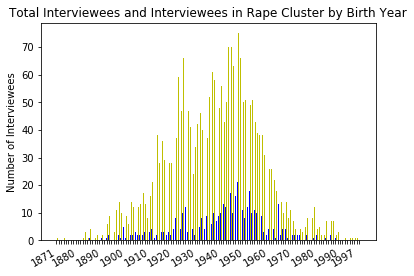

In [60]:
N = 128

ind = np.arange(N) 
values=[]
totals=[]

# some example data

values=hits_formatted
    
    
values = np.array(values)
total=np.array(total)


x = range(len(values))


# and plot it
space=["","","","","","","","",""]
fig, ax = pyplot.subplots()
hm=ax.bar(ind, values, 0.35, color="b")
total=ax.bar(ind+.35, total, .35, color="y")
ax.set_xticks(ind)
ax.set_xticklabels([1871,"","","","","","","","",1880]+space+[1890]+space+[1900]+space+[1910]+space+[1920]+space+[1930]+space+[1940]+space+[1950]+space+[1960]+space+[1970]+space+[1980]+space+[1990, "","","","","","",1997])
ax.set_title('Total Interviewees and Interviewees in Rape Cluster by Birth Year')
ax.set_ylabel('Number of Interviewees')
pyplot.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')